In [2]:
import pandas as pd
# 두 단계 밖으로 나갔다가 data 폴더로 들어가는 경로
customer = pd.read_csv('../../data/customer_hm.csv') 
transactions = pd.read_csv('../../data/transactions_hm.csv')
articles = pd.read_csv('../../data/articles_hm.csv')

#원본 데이터 지키기 위해서 copy
df_cust = customer.copy()
df_tran = transactions.copy()
df_art = articles.copy()


###customer 데이터 전처리###
#고객 테이블 결측치 확인
df_cust.isnull().sum()

# fashion_news_frequency가 결측치인 데이터만 추출
missing_data = df_cust[df_cust['fashion_news_frequency'].isnull()]
missing_data

# FN이 1이고, Active가 0인 fashion_news_frequency의 고유값별 빈도 확인
df_cust[(df_cust['FN'] == 1) & (df_cust['Active'] == 0)
]['fashion_news_frequency'].value_counts(dropna=False)

# 결측치 'Regularly'으로 채우기
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].fillna('Regularly')

#  (문자형 정수형으로 매핑) 사전 정의
status_map = {'ACTIVE': 2, 'PRE-CREATE': 1, 'LEFT CLUB': 0}
frequency_map = {'Regularly': 2, 'Monthly': 1, 'NONE': 0}

#  매핑 적용
df_cust['club_member_status'] = df_cust['club_member_status'].map(status_map)
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].map(frequency_map)


# 나이를 나이대별로 나눠 파생변수 생성
def cate_age(age):
    if age < 20: return '10대'
    elif age < 30: return '20대'
    elif age < 40: return '30대'
    elif age < 50: return '40대'
    elif age < 60: return'50대'
    else: return '60대 이상'

df_cust['age_segment'] = df_cust['age'].apply(cate_age)


###transactions 데이터 전처리###

#join을 위해 동일한 타입으로 변환
df_tran['customer_id']= df_tran['customer_id'].astype(str)
df_cust['customer_id']= df_cust['customer_id'].astype(str)

df_tran['article_id']= df_tran['article_id'].astype(str).str.zfill(10)

#데이터 크기 및 중복 확인

print("df_tran (복사본) 크기:", df_tran.shape)
print("중복 데이터 수:", df_tran.duplicated().sum())

#중복된 거래 로그를 제거하여 분석 결과의 왜곡을 방지
df_tran.drop_duplicates(inplace=True)

# 날짜 타입 변환
df_tran['t_dat'] = pd.to_datetime(df_tran['t_dat'], format='%Y-%m-%d')

# 판매 채널 컬럼 생성 및 값 변환
df_tran["channel"] = df_tran["sales_channel_id"].map({1: "오프라인", 2: "온라인"})
df_tran["channel"].value_counts() 
numbs = df_tran["channel"].value_counts()
print("온라인:", f"{numbs['온라인']:,}")
print("오프라인:", f"{numbs['오프라인']:,}")
print("전체 거래 건수:", f"{df_tran.shape[0]:,}")


# 가격 데이터 분포 확인
df_tran['price'].describe() 
print("price가 0.1 이상:", len(df_tran[df_tran["price"] >= 0.1]))
print("price가 0.2 이상:", len(df_tran[df_tran["price"] >= 0.2]))
print("price가 0.3 이상:", len(df_tran[df_tran["price"] >= 0.3]))
print("price가 0.4 이상:", len(df_tran[df_tran["price"] >= 0.4]))
print("price가 0.5 이상:", len(df_tran[df_tran["price"] >= 0.5]))

#고가 거래 분리 및 채널 확인
high_price_transactions = df_tran[df_tran["price"] >= 0.4]
high_price_transactions['sales_channel_id'].replace({1: 'Offline', 2: 'Online'}).value_counts() 

#월 컬럼 생성
df_tran['year_month'] = df_tran['t_dat'].dt.to_period('M') 

#월별 거래 건수 & 매출액 계산
monthly_sales = df_tran.groupby('year_month').size()
monthly_price = df_tran.groupby('year_month')['price'].sum()

print(monthly_price)

# 최고 매출 월 
best_month = monthly_price.idxmax()
best_value = monthly_price.max()

print("가장 매출이 높은 달:", best_month)
print("그 달의 매출:", best_value) 


###article 데이터 전처리###

# 1. ID 형식 통일 (다른 테이블과 과정 동일해야함. 회의 때 의견 통일)
# article_id를 10자리 문자열로 변환하여 앞의 '0'이 잘리지 않게
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

# 2. 결측치(NULL) 제어 (detail_desc의 NULL값을 No Description로)
df_art['detail_desc'] = df_art['detail_desc'].fillna('No Description')

# 3. 불필요 컬럼 제거 (메모리 줄이기)
# Name(이름)이 존재하여 중복 정보인 Code(코드성 숫자) 컬럼 불필요함. 제거!
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
df_art_cleaned = df_art.drop(columns=cols_to_drop) 

# 매핑 및 파생변수 설정 (시즌별 / 고관여&저관여 / 신상품 여부 / 색감 여부)
# 1. 시즌 별 매핑 (product_season) / 시즌성 구분을 위한 키워드 정의
def get_season(section):
    section = section.lower()
    # FW
    if any(kw in section for kw in ['outerwear', 'nightwear', 'socks', 'tights', 'knitted']):
        return 'FW'
    # SS
    elif any(kw in section for kw in ['swimwear', 'sport', 'shorts', 'sandals']):
        return 'SS'
    # 두루두루 아이템(all season)
    else:
        return 'All-Season'

#파생변수 생성 및 이름만 조금 더 직관적으로 분류
df_art_cleaned['product_season'] = df_art_cleaned['section_name'].apply(get_season)
df_art_cleaned['category_main'] = df_art_cleaned['index_group_name']    #원본 보존하고 복사해서 이름 변경 (메인 카테고리 정의)


# 2. 저관여/고관여 제품 분류?
def get_involvement_strategy(row):
    garment = str(row['garment_group_name']).lower()
    section = str(row['section_name']).lower()
    
    # 1. 저관여 (베이직)
    if any(kw in garment for kw in ['basic', 'underwear', 'socks', 'jersey']) or \
       'basic' in section:
        return 'Low_Involvement_Basic'
    
    # 2. 고관여 (전략템/트렌드템)
    elif any(kw in garment for kw in ['knitwear', 'outerwear', 'dresses']) or \
         any(kw in section for kw in ['trend', 'special']):
        return 'High_Involvement_Strategic'
    
    else:
        return 'General_Fashion'
# 파생변수 생성
df_art_cleaned['product_strategy'] = df_art_cleaned.apply(get_involvement_strategy, axis=1)
display(df_art_cleaned[['article_id', 'prod_name', 'product_strategy']].head()) #확인용


# 3. 신상품/트렌드 여부 파생변수
def check_newness(row):
    text = (str(row['prod_name']) + " " + str(row['detail_desc'])).lower()
    new_keywords = ['new', 'collection', 'latest', 'trend', 'exclusive']
    
    if any(kw in text for kw in new_keywords):
        return 'New_Arrival'
    return 'Regular_Carryover'
# 파생변수 생성
df_art_cleaned['is_new'] = df_art_cleaned.apply(check_newness, axis=1)

# 4. 색상 톤 그룹화 
def get_color_tone(color):
    color = str(color).lower()
    dark_colors = ['black', 'dark blue', 'dark grey', 'dark red', 'navy blue', 'dark green', 'anthracite']
    light_colors = ['white', 'light beige', 'off white', 'light pink', 'light blue', 'yellowish brown']
    
    if any(dc in color for dc in dark_colors):
        return 'Dark_Tone'
    elif any(lc in color for lc in light_colors):
        return 'Light_Tone'
    else:
        return 'Neutral_Tone'
# 파생변수 생성
df_art_cleaned['color_tone'] = df_art_cleaned['colour_group_name'].apply(get_color_tone)

df_tran (복사본) 크기: (1048575, 5)
중복 데이터 수: 8474
온라인: 721,488
오프라인: 318,613
전체 거래 건수: 1,040,101
price가 0.1 이상: 10704
price가 0.2 이상: 719
price가 0.3 이상: 126
price가 0.4 이상: 29
price가 0.5 이상: 2
year_month
2019-01    2129.926131
2019-02    1989.217641
2019-03    2374.905504
2019-04    2703.443538
2019-05    2748.199469
2019-06    3088.776976
2019-07    2552.035334
2019-08    1943.422489
2019-09    2559.226862
2019-10    2358.486793
2019-11    2463.769270
2019-12    1985.492149
Freq: M, Name: price, dtype: float64
가장 매출이 높은 달: 2019-06
그 달의 매출: 3088.776976142


,article_id,prod_name,product_strategy
0,0108775015,Strap top,Low_Involvement_Basic
1,0108775044,Strap top,Low_Involvement_Basic
2,0108775051,Strap top (1),Low_Involvement_Basic
3,0110065001,OP T-shirt (Idro),General_Fashion
4,0110065002,OP T-shirt (Idro),General_Fashion


In [5]:
#  첫 번째 조인: 거래 + 고객 (customer_id 기준)
merged_df = pd.merge(df_tran, df_cust, on='customer_id', how='left')

# 두 번째 조인: (거래+고객) + 상품 (article_id 기준)
final_df = pd.merge(merged_df, df_art_cleaned, on='article_id', how='left')

# 결과 확인
print(df_tran.shape)
print(final_df.shape)
final_df.head()

(1040101, 7)
(1040101, 32)


,t_dat,customer_id,article_id,price,sales_channel_id,channel,year_month,FN,Active,club_member_status,...,index_name,index_group_name,section_name,garment_group_name,detail_desc,product_season,category_main,product_strategy,is_new,color_tone
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,0698328010,0.016932,2,온라인,2019-11,1.0,1.0,2.0,...,Divided,Divided,Divided Collection,Jersey Fancy,Top in lightweight sweatshirt fabric with drop...,All-Season,Divided,Low_Involvement_Basic,Regular_Carryover,Dark_Tone
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,0760597002,0.033881,2,온라인,2019-05,0.0,0.0,2.0,...,Ladieswear,Ladieswear,Womens Casual,Jersey Fancy,"Short-sleeved blouse in stretch, textured jers...",All-Season,Ladieswear,Low_Involvement_Basic,Regular_Carryover,Light_Tone
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,0488561032,0.016932,2,온라인,2019-05,1.0,1.0,2.0,...,Menswear,Menswear,Contemporary Casual,Shorts,Knee-length shorts in soft washed cotton with ...,All-Season,Menswear,General_Fashion,Regular_Carryover,Dark_Tone
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,0682771001,0.033881,2,온라인,2019-08,0.0,0.0,2.0,...,Ladies Accessories,Ladieswear,Womens Big accessories,Accessories,Shopper in grained imitation leather with two ...,All-Season,Ladieswear,General_Fashion,Regular_Carryover,Dark_Tone
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,0742400033,0.003220,1,오프라인,2019-08,0.0,0.0,2.0,...,Menswear,Menswear,Men Underwear,Socks and Tights,"Socks in a soft, fine-knit cotton blend with r...",All-Season,Menswear,Low_Involvement_Basic,Regular_Carryover,Light_Tone


In [6]:
final_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1040101 entries, 0 to 1040100
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   t_dat                         1040101 non-null  datetime64[us]
 1   customer_id                   1040101 non-null  str           
 2   article_id                    1040101 non-null  str           
 3   price                         1040101 non-null  float64       
 4   sales_channel_id              1040101 non-null  int64         
 5   channel                       1040101 non-null  str           
 6   year_month                    1040101 non-null  period[M]     
 7   FN                            806367 non-null   float64       
 8   Active                        806367 non-null   float64       
 9   club_member_status            806367 non-null   float64       
 10  fashion_news_frequency        806367 non-null   float64       
 11  age      

In [7]:
final_df.isnull().sum()

t_dat                                0
customer_id                          0
article_id                           0
price                                0
sales_channel_id                     0
channel                              0
year_month                           0
FN                              233734
Active                          233734
club_member_status              233734
fashion_news_frequency          233734
age                             233734
age_segment                     233734
product_code                         0
prod_name                            0
product_type_name                    0
product_group_name                   0
graphical_appearance_name            0
colour_group_name                    0
perceived_colour_value_name          0
perceived_colour_master_name         0
department_name                      0
index_name                           0
index_group_name                     0
section_name                         0
garment_group_name       

In [9]:
# 1. 연령대(age_segment)의 결측치를 'Unknown'으로 채우기
final_df['age_segment'] = final_df['age_segment'].fillna('Unknown')

# 2. 고객 상태(club_member_status)의 결측치를 'Unknown'으로 채우기
final_df['club_member_status'] = final_df['club_member_status'].fillna('Unknown')

final_df['FN'] = final_df['FN'].fillna('Unknown')

final_df['Active'] = final_df['Active'].fillna('Unknown')

final_df['fashion_news_frequency'] = final_df['fashion_news_frequency'].fillna('Unknown')

final_df['age'] = final_df['age'].fillna('Unknown')

# 결측치가 잘 채워졌는지 확인
print(final_df['age_segment'].value_counts())
print(final_df['club_member_status'].value_counts())
print(final_df['FN'].value_counts())
print(final_df['Active'].value_counts())
print(final_df['fashion_news_frequency'].value_counts())    

age_segment
20대        329534
Unknown    233734
30대        164457
50대        135167
40대        125774
60대 이상      37794
10대         13641
Name: count, dtype: int64
club_member_status
2.0        789730
Unknown    233734
1.0         16377
0.0           260
Name: count, dtype: int64
FN
0.0        456900
1.0        349467
Unknown    233734
Name: count, dtype: int64
Active
0.0        461862
1.0        344505
Unknown    233734
Name: count, dtype: int64
fashion_news_frequency
0.0        455837
2.0        350272
Unknown    233734
1.0           258
Name: count, dtype: int64


In [10]:
# 연령대별 비율
final_df['age_segment'].value_counts(normalize=True)*100

age_segment
20대        31.682885
Unknown    22.472241
30대        15.811638
50대        12.995565
40대        12.092479
60대 이상      3.633686
10대         1.311507
Name: proportion, dtype: float64

In [ ]:
#  연령대가 'Unknown'인 데이터만 필터링
df_unknown = final_df[final_df['age_segment'] == 'Unknown']

# 온·오프라인(sales_channel_id) 비중 산출
unknown_channel_ratio = df_unknown['sales_channel_id'].value_counts(normalize=True) * 100

#  결과 출력 (1: 오프라인, 2: 온라인)
print("### 'Unknown' 고객의 전체 구매 채널 비중 ###")
print(f"오프라인(1) 비중: {unknown_channel_ratio.get(1, 0):.1f}%")
print(f"온라인(2) 비중: {unknown_channel_ratio.get(2, 0):.1f}%")

### 'Unknown' 고객의 전체 구매 채널 비중 ###
오프라인(1) 비중: 30.7%
온라인(2) 비중: 69.3%


Unknown 고객의 69%가 온라인에서 발생하고 있음
왜 비회원으로 구매할까? 편해서,, 개인정보때문에,, 회원혜택이 매력적이지 않아서,,

In [ ]:
# 구매 경로별 연령대 비율

# 구매 경로(sales_channel_id)와 연령대(age_segment) 간의 교차표 생성
# normalize='index'를 사용하여 각 경로별 합계를 100%로 맞춤
channel_age_ratio = pd.crosstab(final_df['channel'], 
                                final_df['age_segment'], 
                                normalize='index') * 100


print(channel_age_ratio.round(1))

age_segment  10대   20대   30대   40대   50대  60대 이상  Unknown
channel                                                  
오프라인         1.8  31.0  12.9  13.1  14.4     4.3     22.5
온라인          1.1  32.0  17.1  11.6  12.4     3.4     22.4


온라인, 오프라인의 연령대 비율이 전체적으로 비슷하다.
20대,30대는 온라인 비율이 더 높다.
10대,40대,50대,60대이상은 오프라인 비율이 (조금) 더 높다.

온라인, 오프라인 모두 20대 비중이 높다. 타켓고객층

In [29]:

#  20대 데이터만 필터링
df_20s = final_df[final_df['age_segment'] == '20대']

#  구매 경로별 비중 산출
channel_ratio_20s = df_20s['sales_channel_id'].value_counts(normalize=True) * 100

#  결과 출력 (1: 오프라인, 2: 온라인)
print("### 20대 고객의 구매 채널 비중 ###")
print(f"오프라인(1) 구매 비중: {channel_ratio_20s.get(1, 0):.1f}%")
print(f"온라인(2) 구매 비중: {channel_ratio_20s.get(2, 0):.1f}%")

### 20대 고객의 구매 채널 비중 ###
오프라인(1) 구매 비중: 29.9%
온라인(2) 구매 비중: 70.1%


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

#  연령대별 구매 경로 교차표 생성 및 비율 변환
age_channel_ratio = pd.crosstab(final_df['age_segment'], 
                                final_df['channel'], 
                                normalize='index') * 100

#  결과 수치 확인
print("### 연령대별 온·오프라인 구매 비중 (%) ###")
print(age_channel_ratio.round(1))

### 연령대별 온·오프라인 구매 비중 (%) ###
channel      오프라인   온라인
age_segment            
10대          42.1  57.9
20대          29.9  70.1
30대          25.0  75.0
40대          33.2  66.8
50대          33.9  66.1
60대 이상       35.9  64.1
Unknown      30.7  69.3


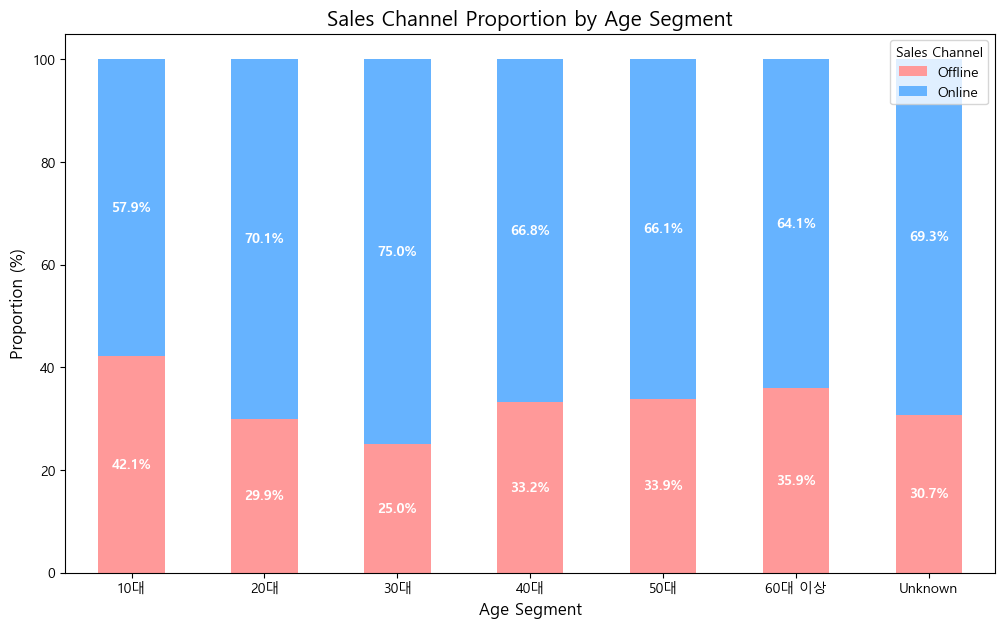

In [25]:
# 시각화 설정
age_channel_ratio.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#ff9999', '#66b3ff'])

# 1. 한글 폰트 설정 (Windows 기준 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

plt.title('Sales Channel Proportion by Age Segment', fontsize=15)
plt.xlabel('Age Segment', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0) # 연령대 글자를 가로로 바르게 표시
plt.legend(title='Sales Channel', loc='upper right')

# 비율 수치를 막대 위에 표시하고 싶다면 아래 반복문 추가 (선택사항)
for i, (off, on) in enumerate(zip(age_channel_ratio['Offline'], age_channel_ratio['Online'])):
    plt.text(i, off/2, f'{off:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, off + on/2, f'{on:.1f}%', ha='center', va='center', color='white', fontweight='bold')

plt.show()

전체 데이터에서 온라인 구매가 더 많은 경향성이 모든 연령대별 구매수에서도 유지되었다.
모든 연령층(Umknown)에서 온라인 구매가 더 높다.

In [31]:
# 신규 고객의 온오프라인 구매 비율

#  신규 고객(PRE-CREATE, 매핑값 1) 데이터만 필터링
df_new_customers = final_df[final_df['club_member_status'] == 1]

#  온·오프라인 채널 비중 산출 (1: 오프라인, 2: 온라인)
new_channel_ratio = df_new_customers['sales_channel_id'].value_counts(normalize=True) * 100

#  결과 출력
print("### 신규 고객 전체의 구매 채널 비중 ###")
print(f"오프라인(1) 비중: {new_channel_ratio.get(1, 0):.1f}%")
print(f"온라인(2) 비중: {new_channel_ratio.get(2, 0):.1f}%")

### 신규 고객 전체의 구매 채널 비중 ###
오프라인(1) 비중: 0.3%
온라인(2) 비중: 99.7%


온라인 구매가 (회원가입)신규고객 유입 경로다. 

### 신규 고객 내 연령대별 비중 (%) ###
age_segment
20대       26.5
30대       24.0
50대       23.0
40대       19.0
60대 이상     6.6
10대        0.9
Name: proportion, dtype: float64


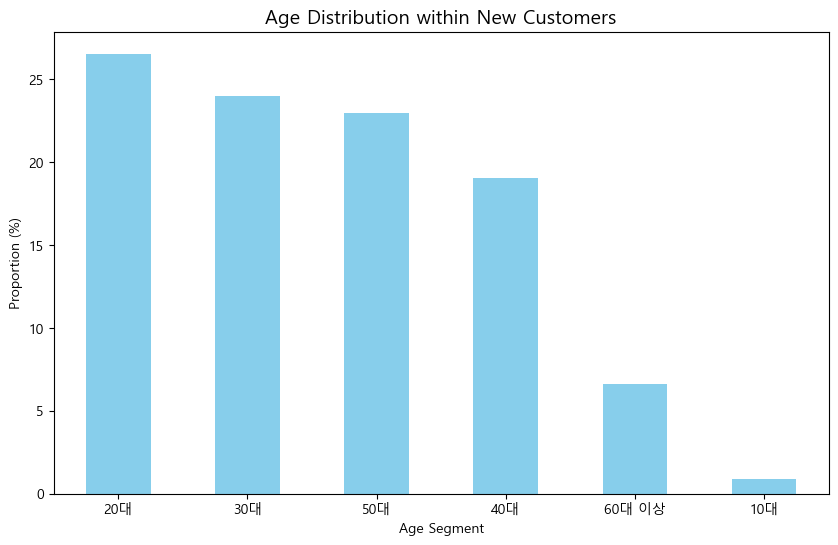

In [32]:

# 신규 고객 데이터만 필터링 (PRE-CREATE = 1)
df_new = final_df[final_df['club_member_status'] == 1]

#  연령대별 비중 산출 (내림차순 정렬)
new_age_ratio = df_new['age_segment'].value_counts(normalize=True) * 100

#  결과 출력
print("### 신규 고객 내 연령대별 비중 (%) ###")
print(new_age_ratio.round(1))

#  시각화 (막대 그래프)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
new_age_ratio.plot(kind='bar', color='skyblue')
plt.title('Age Distribution within New Customers', fontsize=14)
plt.xlabel('Age Segment')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)
plt.show()

신규 고객도 20대,30대가 가장 많다.
신규고객 유치전략: 온라인에서 20대,30대 타켓으로 

In [34]:

#  탈퇴 고객(LEFT CLUB, 매핑값 0) 데이터만 필터링
df_left_customers = final_df[final_df['club_member_status'] == 0]

#  온·오프라인 채널 비중 산출 (1: 오프라인, 2: 온라인)
left_channel_ratio = df_left_customers['sales_channel_id'].value_counts(normalize=True) * 100

# 결과 출력
print("### 탈퇴 고객의 전체 구매 채널 비중 ###")
if not left_channel_ratio.empty:
    print(f"오프라인(1) 비중: {left_channel_ratio.get(1, 0):.1f}%")
    print(f"온라인(2) 비중: {left_channel_ratio.get(2, 0):.1f}%")

### 탈퇴 고객의 전체 구매 채널 비중 ###
오프라인(1) 비중: 6.2%
온라인(2) 비중: 93.8%


신규회원과 마찬가지로 탈퇴회원도 온라인 구매(93%)로 압도적
하지만 원래 온라인 구매가 더 많기 때문에 당연한 결과일 수 도
매력적인 온라인 회원헤택으로 탈퇴회원을 막고 신규회원을 유치할 수 있겠다. 

In [40]:
final_df['club_member_status'].value_counts()

club_member_status
2.0        789730
Unknown    233734
1.0         16377
0.0           260
Name: count, dtype: int64

### 1. 회원 상태별 구매건 수 비중 (%) ###
club_member_status
2.0        75.9
Unknown    22.5
1.0         1.6
0.0         0.0
Name: proportion, dtype: float64


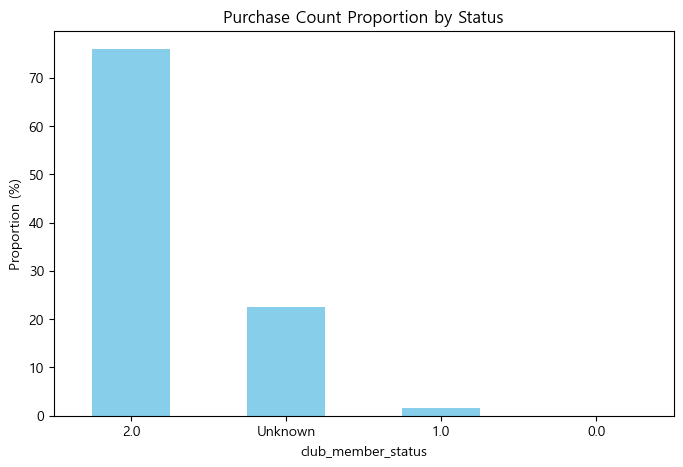

In [39]:
# 전체 거래 데이터에서 회원상태별 비율

#  회원 상태별 구매건 수 비중 계산
status_count_ratio = final_df['club_member_status'].value_counts(normalize=True) * 100

# 결과 출력 (0: 탈퇴, 1: 신규, 2: 활동, Unknown: 미기입)
print("### 1. 회원 상태별 구매건 수 비중 (%) ###")
print(status_count_ratio.round(1))

# 시각화 (막대 그래프)
import matplotlib.pyplot as plt
status_count_ratio.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Purchase Count Proportion by Status')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)
plt.show()

In [38]:
final_df.groupby('club_member_status')['price'].sum()

club_member_status
0.0            7.770949
1.0          497.129321
2.0        21893.364016
Unknown     6498.637871
Name: price, dtype: float64

### 2. 회원 상태별 구매금액 비중 (%) ###
club_member_status
2.0        75.8
Unknown    22.5
1.0         1.7
0.0         0.0
Name: price, dtype: float64


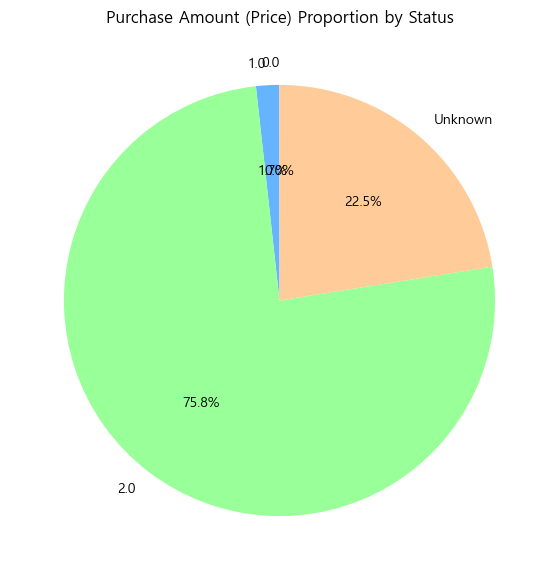

In [37]:
# 회원 상태별로 price 컬럼의 합계를 구한 뒤, 전체 매출에서 차지하는 비율

#  회원 상태별 구매금액(price) 합계 산출
status_price_sum = final_df.groupby('club_member_status')['price'].sum()

#  전체 금액 대비 비중(%)으로 변환
status_price_ratio = (status_price_sum / status_price_sum.sum()) * 100

#  결과 출력
print("### 2. 회원 상태별 구매금액 비중 (%) ###")
print(status_price_ratio.sort_values(ascending=False).round(1))

#  시각화 (파이 차트)
plt.figure(figsize=(7, 7))
plt.pie(status_price_ratio, labels=status_price_ratio.index, autopct='%.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Purchase Amount (Price) Proportion by Status')
plt.show()

In [42]:
# 판매 채널별 총 매출액
final_df.groupby('sales_channel_id')['price'].sum()

sales_channel_id
1     7272.191768
2    21624.710388
Name: price, dtype: float64

In [44]:

#  채널별 구매 가격 합계 계산
channel_price_sum = final_df.groupby('sales_channel_id')['price'].sum()

#  매출 비중(%) 확인
channel_price_pct = (channel_price_sum / channel_price_sum.sum()) * 100
channel_price_pct 

sales_channel_id
1    25.165991
2    74.834009
Name: price, dtype: float64

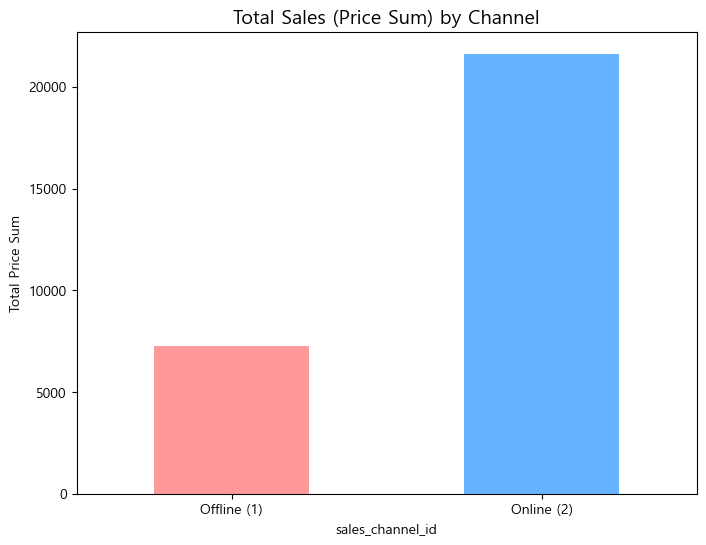

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
channel_price_sum.plot(kind='bar', color=['#ff9999', '#66b3ff'])
plt.title('Total Sales (Price Sum) by Channel', fontsize=14)
plt.xticks([0, 1], ['Offline (1)', 'Online (2)'], rotation=0)
plt.ylabel('Total Price Sum')
plt.show()

In [46]:
# 판매 채널별 구매건 수
final_df['sales_channel_id'].value_counts()

sales_channel_id
2    721488
1    318613
Name: count, dtype: int64

In [47]:
#  판매채널 별 구매 비중(%) 확인
final_df['sales_channel_id'].value_counts(normalize=True)*100

sales_channel_id
2    69.36711
1    30.63289
Name: proportion, dtype: float64

온라인의 구매 비율은 69%, 매출 비율은 74.8%
온라인의 고가구매 비중이 더 높다.

### 전략 그룹별 온·오프라인 구매 비중 ###


,Offline (%),Online (%)
product_strategy,,
General_Fashion,28.7,71.3
High_Involvement_Strategic,26.8,73.2
Low_Involvement_Basic,36.4,63.6


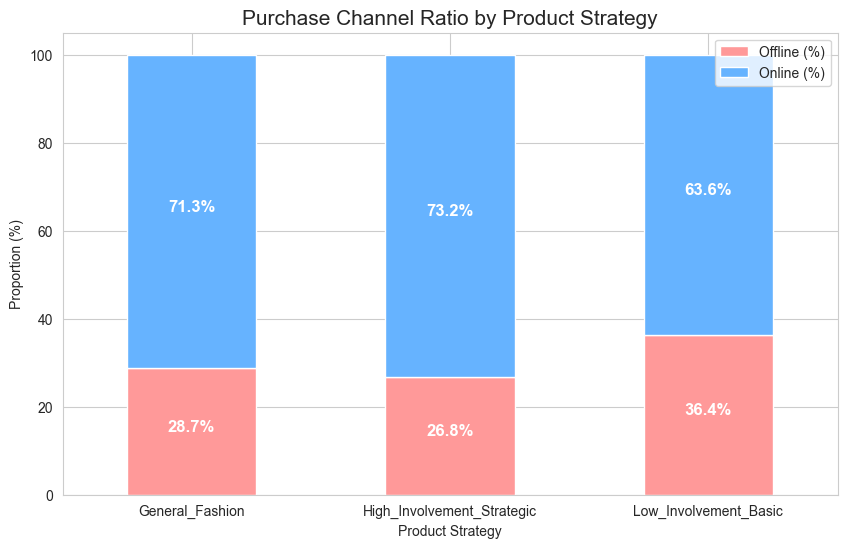

In [14]:
# 사고법: 전략 그룹별로 그룹화(groupby)한 뒤, 채널(1: 오프라인, 2: 온라인)의 비중을 계산한다.

# 1. 전략 그룹별 채널 비중 산출 (normalize=True를 사용해 비율로 변환)
strategy_channel = final_df.groupby('product_strategy')['sales_channel_id'].value_counts(normalize=True).unstack() * 100

# 2. 결과 출력 (가독성을 위해 컬럼명 변경)
strategy_channel.columns = ['Offline (%)', 'Online (%)']
print("### 전략 그룹별 온·오프라인 구매 비중 ###")
display(strategy_channel.round(1))

# 3. 시각화 (누적 막대 그래프 - Stacked Bar Chart)
import matplotlib.pyplot as plt
import numpy as np

strategy_channel.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], figsize=(10, 6))
plt.title('Purchase Channel Ratio by Product Strategy', fontsize=15)
plt.xlabel('Product Strategy')
plt.ylabel('Proportion (%)')
plt.legend(loc='upper right')
plt.xticks(rotation=0)

# 백분율 수치 표시 (선택사항)
for n, x in enumerate([*strategy_channel.index.values]):
    for (proportion, y_loc) in zip(strategy_channel.loc[x],
                                   strategy_channel.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion, 1)}%', 
                 color="white",
                 fontsize=12,
                 fontweight="bold",
                 ha="center")

plt.show()

c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\3888285145.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\3888285145.py:57: UserWa

<Figure size 1500x800 with 0 Axes>

c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


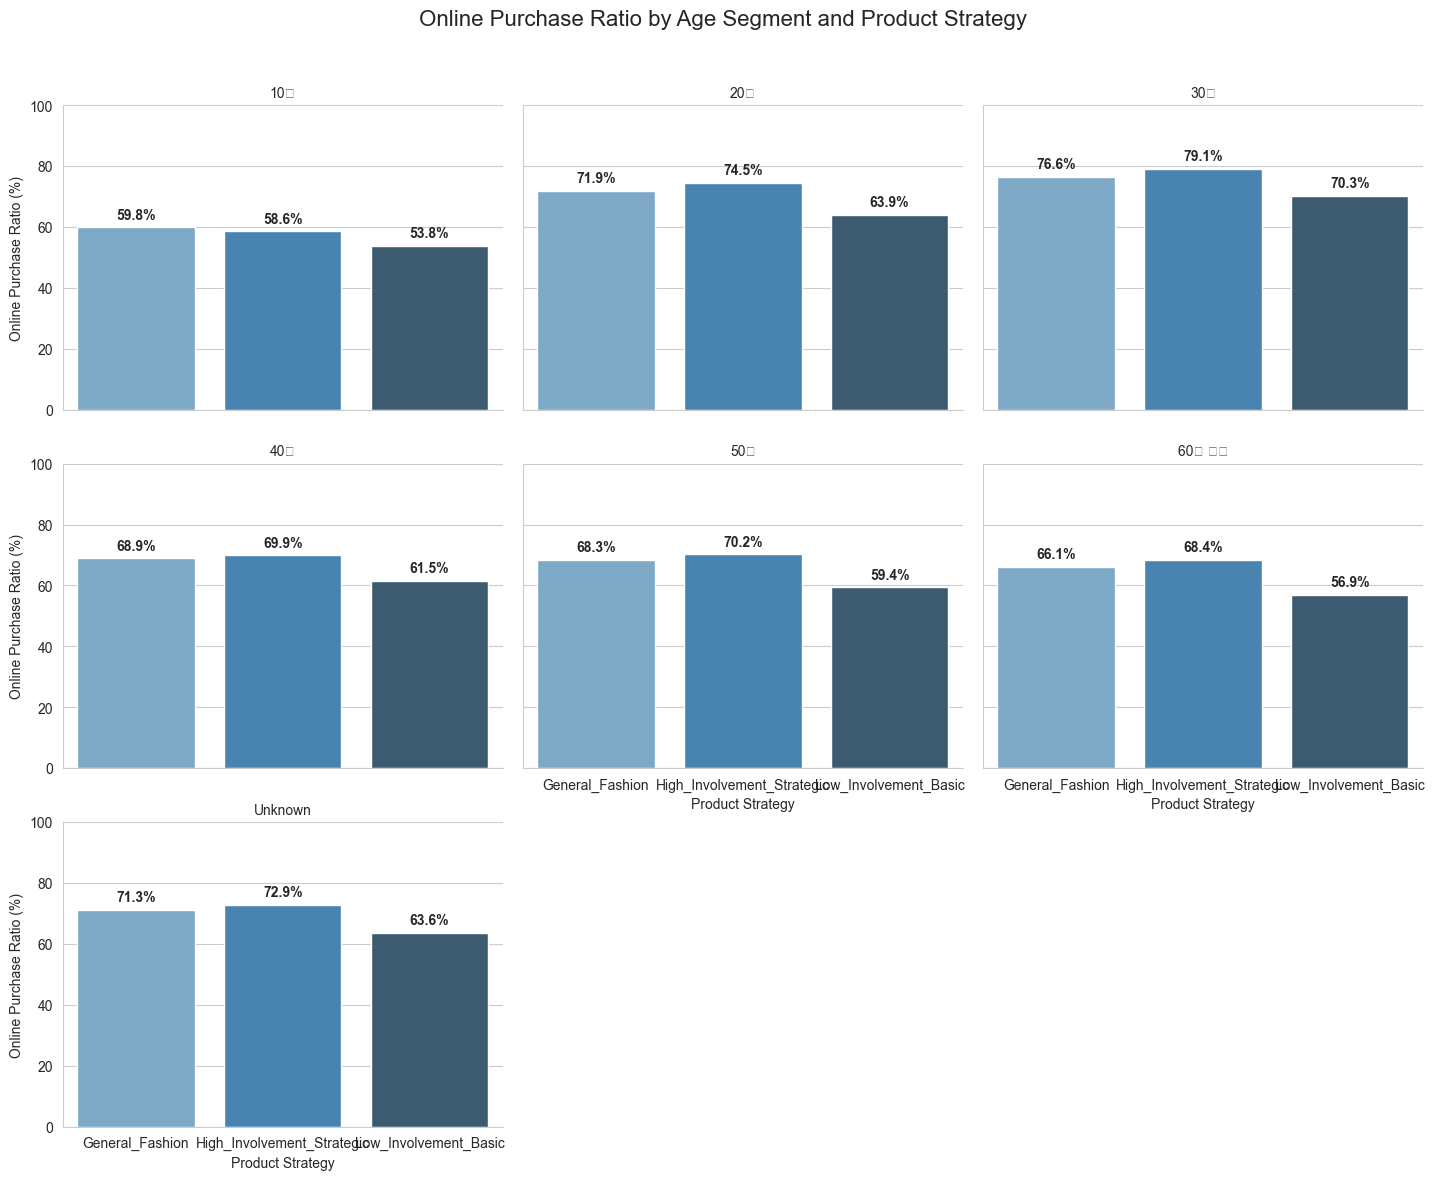

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 그룹화: 연령대, 전략, 채널별로 건수 집계
# age_segment, product_strategy, sales_channel_id 순서로 그룹핑
age_strat_channel = final_df.groupby(['age_segment', 'product_strategy', 'sales_channel_id']).size().unstack(fill_value=0)

# 2. 비중(%)으로 변환
# 각 연령대-전략 조합 내에서 온라인/오프라인의 합이 100이 되도록 계산
age_strat_ratio = age_strat_channel.div(age_strat_channel.sum(axis=1), axis=0) * 100
age_strat_ratio.columns = ['Offline', 'Online']
age_strat_ratio = age_strat_ratio.reset_index()

# 3. 데이터 시각화 (FacetGrid를 사용하여 연령대별로 나누어 보기)
# 온라인 비중만 따로 뽑아서 시각화하면 가독성이 훨씬 좋아집니다.
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# 연령대 순서 정의 (Unknown은 마지막에)
age_order = sorted([a for a in final_df['age_segment'].unique() if a != 'Unknown']) + ['Unknown']

# 연령대별로 product_strategy에 따른 'Online' 구매 비중 그래프
g = sns.catplot(
    data=age_strat_ratio, 
    x='product_strategy', 
    y='Online', 
    col='age_segment', 
    col_order=age_order,
    kind='bar', 
    palette='Blues_d',
    col_wrap=3, # 한 줄에 3개씩 배치
    height=4, 
    aspect=1.2
)

# 그래프 디테일 설정
g.set_axis_labels("Product Strategy", "Online Purchase Ratio (%)")
g.set_titles("{col_name}")
g.set(ylim=(0, 100))

# 각 막대 위에 수치 표시
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=10, fontweight='bold')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Online Purchase Ratio by Age Segment and Product Strategy', fontsize=16)

# 결과 저장
plt.savefig('age_strategy_channel_analysis.png')

C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\48116783.py:34: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\48116783.py:34: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\48116783.py:34: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\sit

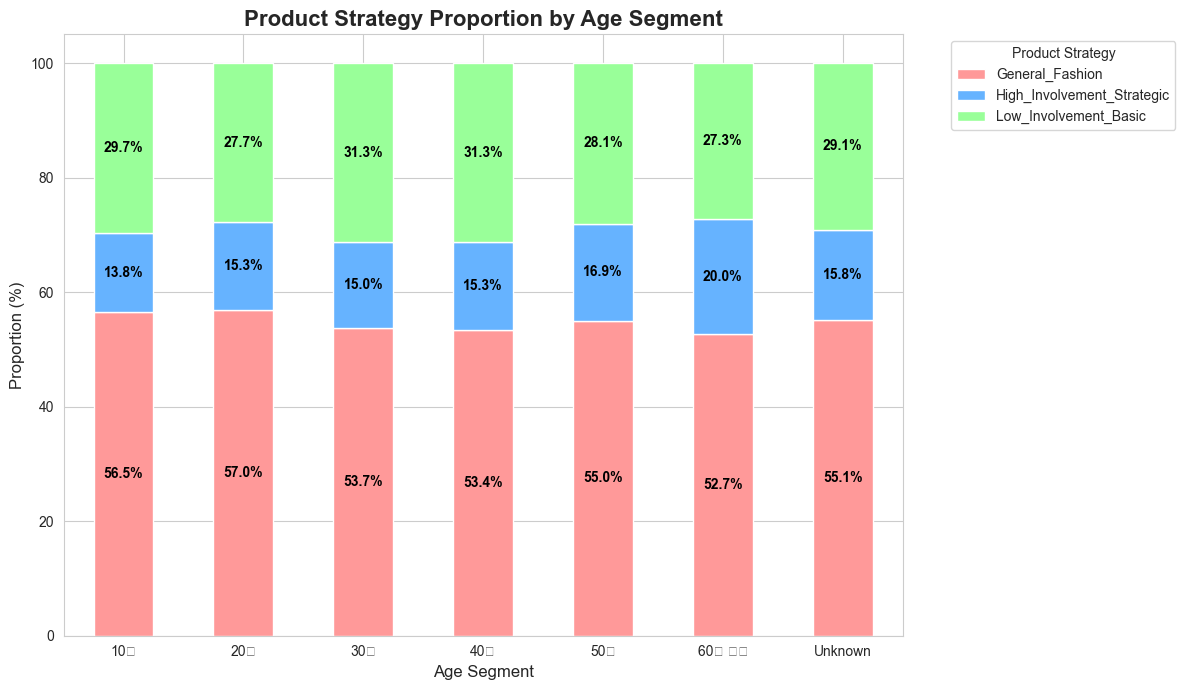

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 연령대와 제품 전략별로 그룹화하여 건수 집계
age_strategy_counts = final_df.groupby(['age_segment', 'product_strategy']).size().unstack(fill_value=0)

# 2. 연령대별 비중(%)으로 변환 (가로 합이 100%가 되도록)
age_strategy_ratio = age_strategy_counts.div(age_strategy_counts.sum(axis=1), axis=0) * 100

# 3. 연령대 정렬 (Unknown은 마지막으로)
age_order = sorted([a for a in age_strategy_ratio.index if a != 'Unknown']) + ['Unknown']
age_strategy_ratio = age_strategy_ratio.reindex(age_order)

# 4. 시각화 (누적 막대 그래프)
ax = age_strategy_ratio.plot(kind='bar', stacked=True, figsize=(12, 7), 
                             color=['#ff9999', '#66b3ff', '#99ff99'])

plt.title('Product Strategy Proportion by Age Segment', fontsize=16, fontweight='bold')
plt.xlabel('Age Segment', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.legend(title='Product Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# 5. 막대 위에 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 5: # 비중이 너무 작으면 숫자가 겹치므로 5% 이상일 때만 표시
        x, y = p.get_xy() 
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), 
                    ha='center', va='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

In [19]:
final_df['product_season'].value_counts()

product_season
All-Season    878547
SS            123322
FW             38232
Name: count, dtype: int64

1/28  분석

팀 인사이트
1. 고객 전환 및 유치 전략 (온라인 위주)
2. 비회원 고객은 2030 여성 고객과 비슷한 경향이 있다는 근거 하에 프로모션 진행해 두마리 토끼를 다 잡아보자!
3. 인기 품목인 all_season 상품으로 프로모션을 진행하면 매출 증가를 기대할 수 있다!

분석 목표
1. 비회원을 회원으로 전환시키면 매출증가를 기대할 수 있나 점검 

    (회원과 바회원의 고객당 평균 구매횟수, 평균 구매액의 차이를 비교)

2. 비회원 고객이 2030 고객과 비슷한 경향을 보인다는 근거 수집 

    (2030고객과 비회원의 고객당 구매횟수, 구매금액(중위값,상위10%값), 최근 구매일을 비교)

3. 프로모션 진행 타켓 도출

분석 1

회원과 바회원의 고객당 평균 구매횟수, 평균 구매액의 차이를 비교

In [27]:
# 1. 고객 상태(club_member_status)별 요약
# ACTIVE(기존), PRE-CREATE(신규), LEFT(탈퇴), Unknown(비회원)
status_comparison = final_df.groupby('club_member_status').agg({
    'customer_id': 'nunique',        # 고객 수
    'price': ['mean', 'count']       # 평균 구매액(객단가), 총 구매 횟수
})

# 2. 1인당 평균 구매 횟수 계산
status_comparison['avg_purchase_per_person'] = status_comparison[('price', 'count')] / status_comparison[('customer_id', 'nunique')]

print("### 고객 상태별 구매 지표 비교 ###")
display(status_comparison)

### 고객 상태별 구매 지표 비교 ###


customer_id     price         avg_purchase_per_person
                       nunique      mean   count                        
club_member_status                                                      
0.0                        112  0.029888     260                2.321429
1.0                      11448  0.030355   16377                1.430556
2.0                     342000  0.027723  789730                2.309152
Unknown                 104675  0.027804  233734                2.232950

기존 회원(2)의 고객당 평균 구매 횟수: 2.31

unknown의 고객당 평균 구매 횟수: 2.23

기존 회원(2)의 평균 구매액(객당가): 0.0278

unknown의 평균 구매액(객당가): 0.028


기존 회원과 unknown의 고객당 평균 구매횟수와 객단가가 너무 유사함

고개당 평균 구매횟수가 2.23이라는 것은 단발성 고객으로 볼 수 없음

-> unknown이 개인정보 수집 동의를 안한 회원일 가능성 있음

분석 목표

비회원을 회원으로 전환시키면 매출증가를 기대할 수 있나 점검

결과

1. 비회원과 기존 회원의 평균 구매횟수와 객당가가 매우 유사, 매출 증가를 기대할 수 있다는 근거 부족

2. unknown이 개인정보 수집 동의를 안한 회원일 가능성

3. ai의 인사이트

 저희 분석 결과, 비회원 전환을 통한 즉각적인 매출 폭증 근거는 부족했습니다. 하지만 2.23회라는 높은 구매 빈도를 가진 이들을 익명의 상태로 두는 것은 비즈니스적으로 큰 리스크입니다. 따라서 '데이터 블랙홀'을 해소하고 개인화 마케팅 기반을 다지는 차원에서의 회원 전환 전략을 제안합니다.....

분석 2

2030고객과 비회원의 고객당 구매횟수, 구매금액(중위값,상위10%값), 마지막 구매일과의 거리을 비교

In [28]:
# 1. 분석 대상 그룹 설정
target_segments = ['20대', '30대', 'Unknown'] 

# 2. 고객별로 그룹화하여 구매 횟수(Frequency) 계산
customer_freq = final_df.groupby(['customer_id', 'age_segment']).size().reset_index(name='purchase_count')

# 3. 20대, 30대, 비회원 데이터만 필터링
target_freq_data = customer_freq[customer_freq['age_segment'].isin(target_segments)]

# 4. 연령대별 구매 횟수의 요약 통계량 비교
frequency_comparison = target_freq_data.groupby('age_segment')['purchase_count'].agg([
    ('고객 수', 'count'),
    ('평균 구매 횟수', 'mean'),
    ('중앙값(가장 일반적인 횟수)', 'median'),
    ('최대 구매 횟수', 'max')
]).round(2)

print("### 2030 vs 비회원: 1인당 구매 빈도 정밀 비교 ###")
display(frequency_comparison)

### 2030 vs 비회원: 1인당 구매 빈도 정밀 비교 ###


,고객 수,평균 구매 횟수,중앙값(가장 일반적인 횟수),최대 구매 횟수
age_segment,,,,
20대,145921,2.26,2.0,52
30대,66100,2.49,2.0,59
Unknown,104675,2.23,1.0,43


20대, 30대, unknown의 고객당 구매횟수 비교

unknown의 고객 당 평균 구매 횟수(2.23)는 20대(2.26)와 매우 유사, 30대는 2.49

but 중앙값의 차이 있음 (unknown은 단발성 고객 분포가 많겠다..)

-->unknown의 고객 당 구매횟수 분포를 뽑아 보면 좋겠다. 시각화 가능?

In [29]:
# 1. 고객별로 총 구매금액(Monetary) 계산
# 한 명의 고객이 여러 번 샀을 때 그 금액을 모두 합친 '인당 총 지출액'을 구합니다.
customer_spending = final_df.groupby(['customer_id', 'age_segment'])['price'].sum().reset_index()

# 2. 비교 대상 설정
target_segments = ['20대', '30대', 'Unknown']

# 3. 대상 그룹만 필터링
target_spending = customer_spending[customer_spending['age_segment'].isin(target_segments)]

# 4. 중위값과 상위 10% 기준값(90% 지점) 계산
# quantile(0.9)는 전체 고객을 한 줄로 세웠을 때 상위 10%가 시작되는 지점의 금액을 말합니다.
spending_metrics = target_spending.groupby('age_segment')['price'].agg([
    ('고객 수', 'count'),
    ('중위값(Median)', 'median'),
    ('상위 10% 기준값(90th Percentile)', lambda x: x.quantile(0.9))
]).round(4)

print("### 2030 vs 비회원: 인당 구매금액(중위값 & 상위 10% 컷) 비교 ###")
display(spending_metrics)

### 2030 vs 비회원: 인당 구매금액(중위값 & 상위 10% 컷) 비교 ###


,고객 수,중위값(Median),상위 10% 기준값(90th Percentile)
age_segment,,,
20대,145921,0.0396,0.1338
30대,66100,0.0424,0.1542
Unknown,104675,0.0398,0.1346


20대, 30대, unknown의 고객당 구매금액(중위값,상위10%값) 비교

unknown의 고객 당 구매금액 중위값(0.0398)는 20대(0.0396)와 매우 유사, 30대는 0.0424

unknown의 상위 10%값(0.1346)도 20대(0.1338)과 매우 유사, 30대는 0.1542

In [30]:
import pandas as pd

# 1. 데이터 내 전체 기준일 설정 (가장 마지막 날짜, 2019-12-31)
latest_date = pd.to_datetime(final_df['t_dat']).max() 

# 2. 고객별 마지막 구매일 확인 (중복 제거 후 최신일만 남김)
recency_df = final_df.groupby(['customer_id', 'age_segment'])['t_dat'].max().reset_index()
recency_df['t_dat'] = pd.to_datetime(recency_df['t_dat'])

# 3. 기준일로부터 며칠 전인가 계산 (상대적 Recency)
recency_df['recency'] = (latest_date - recency_df['t_dat']).dt.days

# 4. 분석 대상 그룹 설정 ('20대', '30대', 'Unknown')
target_segments = ['20대', '30대', 'Unknown']
target_recency = recency_df[recency_df['age_segment'].isin(target_segments)]

# 5. 그룹별 Recency 요약 통계량 비교
# 멘토님 가이드: 평균(mean)보다 중앙값(median)을 중점적으로 확인
recency_comparison = target_recency.groupby('age_segment')['recency'].agg([
    ('고객 수', 'count'),
    ('평균 경과일(Mean)', 'mean'),
    ('중앙 경과일(Median)', 'median'),
    ('가장 오래된 고객(Max)', 'max')
]).round(1)

print(f"### 분석 기준일 (데이터 내 마지막 날): {latest_date.date()} ###")
print("### 2030 vs 비회원: 상대적 최근성(Recency) 정밀 비교 ###")
display(recency_comparison)

### 분석 기준일 (데이터 내 마지막 날): 2019-12-31 ###
### 2030 vs 비회원: 상대적 최근성(Recency) 정밀 비교 ###


,고객 수,평균 경과일(Mean),중앙 경과일(Median),가장 오래된 고객(Max)
age_segment,,,,
20대,145921,149.2,147.0,364
30대,66100,152.1,147.0,364
Unknown,104675,152.0,147.0,364


20대, 30대, unknown의 마지막 구매일과의 평균 거리 비교

unknown의 마지막 구매일과의 평균 거리(152.0)은 30대(152.1)과 매우 유사, 20대는 149.2

결과

2030고객과 unknown의 고객당 구매횟수와 구매금액(중위값,상위 10%값)은 20대와 유사하고, 마지막 구매일과의 거리는 30대와 유사하다.

그러므로 unknown은 2030고객과 유사한 패턴을 보인다?? 다른 연령대와도 비교가 필요해보임..

추가 분석

모든 연령대와 비교해보자!

In [32]:

#  고객별로 그룹화하여 구매 횟수(Frequency) 계산
customer_freq = final_df.groupby(['customer_id', 'age_segment']).size().reset_index(name='purchase_count')


#  연령대별 구매 횟수의 요약 통계량 비교
frequency_comparison = customer_freq.groupby('age_segment')['purchase_count'].agg([
    ('고객 수', 'count'),
    ('평균 구매 횟수', 'mean'),
    ('중앙값(가장 일반적인 횟수)', 'median'),
    ('최대 구매 횟수', 'max')
]).round(2)

display(frequency_comparison)

,고객 수,평균 구매 횟수,중앙값(가장 일반적인 횟수),최대 구매 횟수
age_segment,,,,
10대,8697,1.57,1.0,14
20대,145921,2.26,2.0,52
30대,66100,2.49,2.0,59
40대,53264,2.36,2.0,44
50대,60761,2.22,1.0,43
60대 이상,18817,2.01,1.0,37
Unknown,104675,2.23,1.0,43


unknown이 고개당 구매횟수가 50대랑 더 유사하네?!

In [33]:
# 1. 고객별로 총 구매금액(Monetary) 계산
# 한 명의 고객이 여러 번 샀을 때 그 금액을 모두 합친 '인당 총 지출액'을 구합니다.
customer_spending = final_df.groupby(['customer_id', 'age_segment'])['price'].sum().reset_index()


# 4. 중위값과 상위 10% 기준값(90% 지점) 계산
# quantile(0.9)는 전체 고객을 한 줄로 세웠을 때 상위 10%가 시작되는 지점의 금액을 말합니다.
spending_metrics = customer_spending.groupby('age_segment')['price'].agg([
    ('고객 수', 'count'),
    ('중위값(Median)', 'median'),
    ('상위 10% 기준값(90th Percentile)', lambda x: x.quantile(0.9))
]).round(4)

display(spending_metrics)

,고객 수,중위값(Median),상위 10% 기준값(90th Percentile)
age_segment,,,
10대,8697,0.0288,0.0744
20대,145921,0.0396,0.1338
30대,66100,0.0424,0.1542
40대,53264,0.0423,0.1406
50대,60761,0.0424,0.1389
60대 이상,18817,0.0388,0.1274
Unknown,104675,0.0398,0.1346


unknown의 고객당 구매액은 20대와 제일 유사하다!

In [35]:
import pandas as pd

# 1. 데이터 내 전체 기준일 설정 (가장 마지막 날짜, 2019-12-31)
latest_date = pd.to_datetime(final_df['t_dat']).max() 

# 2. 고객별 마지막 구매일 확인 (중복 제거 후 최신일만 남김)
recency_df = final_df.groupby(['customer_id', 'age_segment'])['t_dat'].max().reset_index()
recency_df['t_dat'] = pd.to_datetime(recency_df['t_dat'])

# 3. 기준일로부터 며칠 전인가 계산 (상대적 Recency)
recency_df['recency'] = (latest_date - recency_df['t_dat']).dt.days

# 5. 그룹별 Recency 요약 통계량 비교
# 멘토님 가이드: 평균(mean)보다 중앙값(median)을 중점적으로 확인
recency_comparison = recency_df.groupby('age_segment')['recency'].agg([
    ('고객 수', 'count'),
    ('평균 경과일(Mean)', 'mean'),
    ('중앙 경과일(Median)', 'median'),
    ('가장 오래된 고객(Max)', 'max')
]).round(1)

print(f"### 분석 기준일 (데이터 내 마지막 날): {latest_date.date()} ###")
display(recency_comparison)

### 분석 기준일 (데이터 내 마지막 날): 2019-12-31 ###


,고객 수,평균 경과일(Mean),중앙 경과일(Median),가장 오래된 고객(Max)
age_segment,,,,
10대,8697,151.6,156.0,364
20대,145921,149.2,147.0,364
30대,66100,152.1,147.0,364
40대,53264,155.0,153.0,364
50대,60761,155.2,154.0,364
60대 이상,18817,158.3,153.0,364
Unknown,104675,152.0,147.0,364


unknown의 마지막 구매일과의 거리는 30대와 제일 유사하다!

결과

nknown의 고객당 구매횟수는 50대와 유사하고,

구매금액(중위값,상위 10%값)은 20대와 유사하고, 

마지막 구매일과의 거리는 30대와 유사하다.

h&m고객 비율은 20대, unknown, 30대, 50대 순이다. 비율이 많은 걸 따라가는 게 당연한 결과면 어쩌지?

특정 연령대의 특징을 따르지 않는 거 아닐까?

ai의 인사이트ㅎㅎ

Unknown은 특정 연령대의 특징을 따르지 않고 모든 지표에서 2위권의 준수한 성적을 냅니다. 이는 이 집단이 H&M 전체 고객의 특징을 그대로 투영하는 '축소판'임을 의미합니다. 

Unknown 집단은 특정 연령대의 특성을 보이기보다 전 연령대의 우량한 지표가 평균화된 혼합 집단으로 분석되었습니다. 이들은 개별 지표에서 모두 상위권을 차지하는 핵심 매출원이지만, 식별 정보가 없어 타겟팅 마케팅이 불가능한 상태입니다. 따라서 회원 전환을 통해 이 '익명의 거대 집단'을 연령별로 구체화하여 관리 효율을 극대화해야 합니다.

In [36]:
final_df['age_segment'].value_counts()

age_segment
20대        329534
Unknown    233734
30대        164457
50대        135167
40대        125774
60대 이상      37794
10대         13641
Name: count, dtype: int64

분석3

unknown과 연령대 별 고객의 올시즌 구매 비중 비교

In [37]:
# 1. 20대 고객 데이터만 필터링
df_20s = final_df[final_df['age_segment'] == '20대']

# 2. 전체 구매 횟수 계산
total_purchase_count_20s = len(df_20s)

# 3. 올시즌 구매 횟수 계산 
seasonal_purchase_count_20s = len(df_20s[df_20s['product_season']== 'All-Season'])

# 4. 비중 계산
seasonal_ratio_20s = (seasonal_purchase_count_20s / total_purchase_count_20s) * 100

print(f"### 20대 고객 구매 특성 분석 ###")
print(f"1. 전체 구매 횟수: {total_purchase_count_20s:,}건")
print(f"2. 올시즌(시즌성) 구매 횟수: {seasonal_purchase_count_20s:,}건")
print(f"3. 올시즌 구매 비중: {seasonal_ratio_20s:.2f}%")

### 20대 고객 구매 특성 분석 ###
1. 전체 구매 횟수: 329,534건
2. 올시즌(시즌성) 구매 횟수: 273,501건
3. 올시즌 구매 비중: 83.00%


In [38]:
# 1. 30대 고객 데이터만 필터링
df_30s = final_df[final_df['age_segment'] == '30대']

# 2. 전체 구매 횟수 계산
total_purchase_count_30s = len(df_30s)

# 3. 올시즌 구매 횟수 계산 
seasonal_purchase_count_30s = len(df_30s[df_30s['product_season']== 'All-Season'])

# 4. 비중 계산
seasonal_ratio_30s = (seasonal_purchase_count_30s / total_purchase_count_30s) * 100

print(f"### 30대 고객 구매 특성 분석 ###")
print(f"1. 전체 구매 횟수: {total_purchase_count_30s:,}건")
print(f"2. 올시즌(시즌성) 구매 횟수: {seasonal_purchase_count_30s:,}건")
print(f"3. 올시즌 구매 비중: {seasonal_ratio_30s:.2f}%")

### 30대 고객 구매 특성 분석 ###
1. 전체 구매 횟수: 164,457건
2. 올시즌(시즌성) 구매 횟수: 138,494건
3. 올시즌 구매 비중: 84.21%


In [39]:
# 1. unknown 고객 데이터만 필터링
df_UN = final_df[final_df['age_segment'] == 'Unknown']

# 2. 전체 구매 횟수 계산
total_purchase_count_UN = len(df_UN)

# 3. 올시즌 구매 횟수 계산 
seasonal_purchase_count_UN = len(df_UN[df_UN['product_season']== 'All-Season'])

# 4. 비중 계산
seasonal_ratio_UN = (seasonal_purchase_count_UN / total_purchase_count_UN) * 100

print(f"### UN 고객 구매 특성 분석 ###")
print(f"1. 전체 구매 횟수: {total_purchase_count_UN:,}건")
print(f"2. 올시즌(시즌성) 구매 횟수: {seasonal_purchase_count_UN:,}건")
print(f"3. 올시즌 구매 비중: {seasonal_ratio_UN:.2f}%")

### UN 고객 구매 특성 분석 ###
1. 전체 구매 횟수: 233,734건
2. 올시즌(시즌성) 구매 횟수: 197,522건
3. 올시즌 구매 비중: 84.51%


In [41]:
# 1. 연령대별로 그룹을 묶어서 전체 구매 건수와 All-Season 구매 건수를 한 번에 계산합니다.
all_season_analysis = final_df.groupby('age_segment').agg(
    total_count=('product_season', 'count'), # 각 연령대별 전체 영수증 개수
    all_season_count=('product_season', lambda x: (x == 'All-Season').sum()) # 그 중 All-Season인 것만 합계
).reset_index()

# 2. 비중(%) 계산하기 (All-Season 건수 / 전체 건수 * 100)
all_season_analysis['all_season_ratio'] = (all_season_analysis['all_season_count'] / all_season_analysis['total_count']) * 100

# 3. 보기 좋게 반올림하고 정렬하기
all_season_analysis['all_season_ratio'] = all_season_analysis['all_season_ratio'].round(2)

print("### 모든 연령대별 All-Season(기본템) 구매 비중 ###")
display(all_season_analysis)

### 모든 연령대별 All-Season(기본템) 구매 비중 ###


,age_segment,total_count,all_season_count,all_season_ratio
0,10대,13641,11414,83.67
1,20대,329534,273501,83.00
2,30대,164457,138494,84.21
3,40대,125774,107904,85.79
4,50대,135167,115815,85.68
5,60대 이상,37794,33897,89.69
6,Unknown,233734,197522,84.51


In [40]:

#  전체 구매 횟수 계산
total_purchase_count = len(final_df)

# 3. 올시즌 구매 횟수 계산 
seasonal_purchase_count = len(final_df[final_df['product_season']== 'All-Season'])

# 4. 비중 계산
seasonal_ratio = (seasonal_purchase_count / total_purchase_count) * 100

print(f"### 전체 고객 구매 특성 분석 ###")
print(f"1. 전체 구매 횟수: {total_purchase_count:,}건")
print(f"2. 올시즌(시즌성) 구매 횟수: {seasonal_purchase_count:,}건")
print(f"3. 올시즌 구매 비중: {seasonal_ratio:.2f}%")

### 전체 고객 구매 특성 분석 ###
1. 전체 구매 횟수: 1,040,101건
2. 올시즌(시즌성) 구매 횟수: 878,547건
3. 올시즌 구매 비중: 84.47%


unknown의 올시즌 구매 비중(84.51%)은 30대(84.21%)와 제일 유사하다

근데 전체 고객의 올시즌 구매 비중(84.47%)과 더 유사하다?

ai의 의견(Unknown 집단은 특정 연령대의 특성을 보이기보다 전 연령대의 우량한 지표가 평균화된 혼합 집단으로 분석)이 더 지지되는 결과?

추가 분석

unknown의 고객 당 구매횟수 분포 시각화

C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\1268055434.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plot_data, x='purchase_count', palette='viridis')


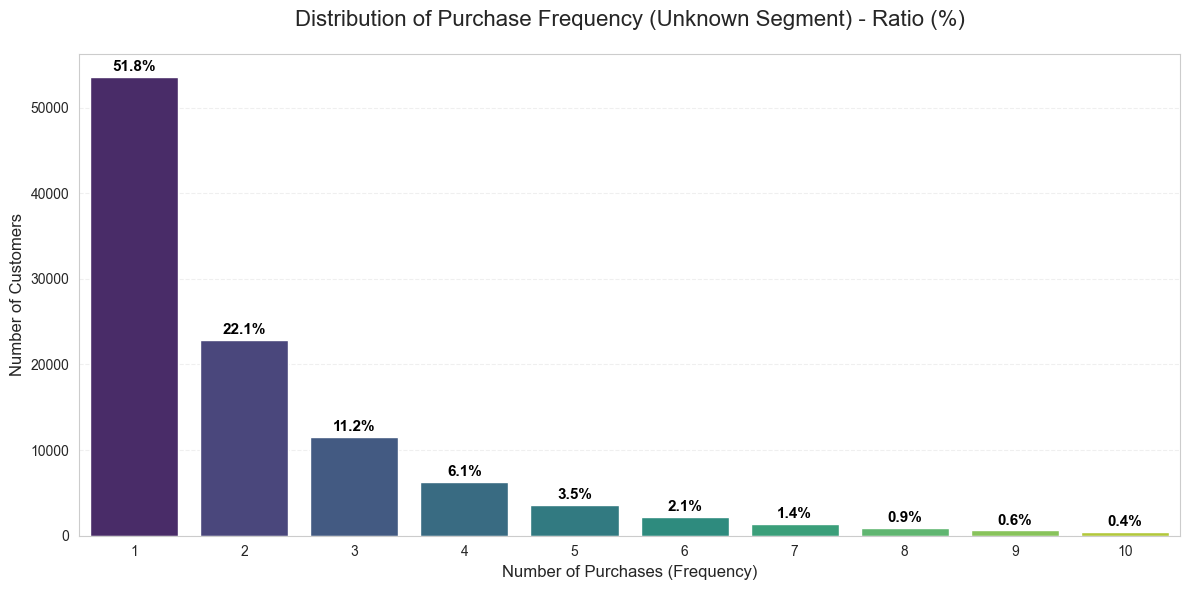

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Unknown 고객만 필터링하여 고객별 구매 횟수 계산
unknown_freq = final_df[final_df['age_segment'] == 'Unknown'].groupby('customer_id').size().reset_index(name='purchase_count')

# 분석 대상 데이터 (구매 횟수 10회 이하)
plot_data = unknown_freq[unknown_freq['purchase_count'] <= 10]
# 비율 계산을 위한 전체 고객 수
total_customers = len(plot_data)

# 2. 시각화 설정
plt.figure(figsize=(12, 6))

# 3. 구매 횟수별 고객 수 그래프
sns.countplot(data=plot_data, x='purchase_count', palette='viridis')

# 4. 그래프 꾸미기
plt.title('Distribution of Purchase Frequency (Unknown Segment) - Ratio (%)', fontsize=16, pad=20)
plt.xlabel('Number of Purchases (Frequency)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 5. 막대 위에 비율(%) 표시하기
ax = plt.gca()
for p in ax.patches:
    # 비율 계산: (막대 높이 / 전체 고객 수) * 100
    percentage = f'{(100 * p.get_height() / total_customers):.1f}%'
    
    # 위치 지정
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    
    ax.annotate(percentage, (x, y),
                ha='center', va='center', fontsize=11, 
                fontweight='bold', color='black', xytext=(0, 7),
                textcoords='offset points')

plt.tight_layout()
# 파일로 저장하여 확인하세요!
plt.savefig('unknown_purchase_ratio.png')

기존고객(2)당 구매횟수 비율 시각화

C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\2993044507.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plot_data_active, x='purchase_count', palette='magma')


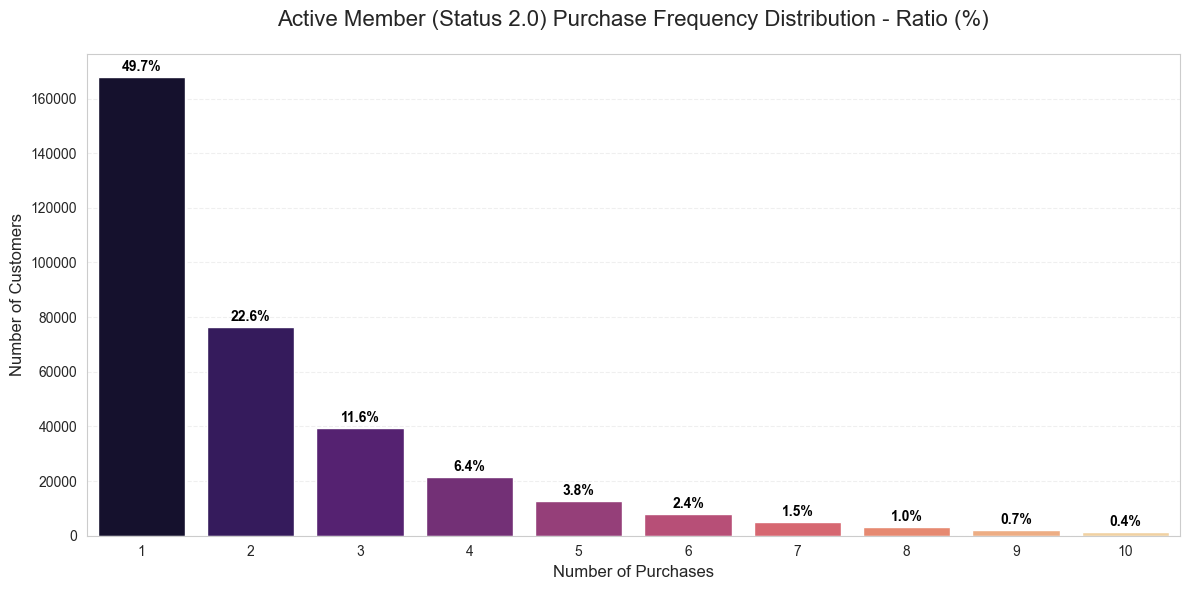

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 기존 활동 회원(Status 2.0)만 필터링
# 데이터프레임의 값 타입에 따라 2.0 (숫자) 또는 '2.0' (문자)로 수정될 수 있습니다.
active_member_df = final_df[final_df['club_member_status'] == 2.0]

# 2. 고객별로 구매 횟수(Frequency) 계산
active_member_freq = active_member_df.groupby('customer_id').size().reset_index(name='purchase_count')

# 분석 대상 데이터 (구매 횟수 10회 이하)
plot_data_active = active_member_freq[active_member_freq['purchase_count'] <= 10]
# 비율 계산을 위한 해당 그룹의 전체 고객 수
total_active_customers = len(plot_data_active)

# 3. 시각화 설정
plt.figure(figsize=(12, 6))

# 4. 구매 횟수별 고객 수 그래프
sns.countplot(data=plot_data_active, x='purchase_count', palette='magma')

# 5. 그래프 꾸미기
plt.title('Active Member (Status 2.0) Purchase Frequency Distribution - Ratio (%)', fontsize=16, pad=20)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 6. 막대 위에 비율(%) 표시하기
ax = plt.gca()
for p in ax.patches:
    # 비율 계산: (막대 높이 / 이 그룹의 전체 고객 수) * 100
    percentage = f'{(100 * p.get_height() / total_active_customers):.1f}%'
    
    # 위치 지정
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    
    ax.annotate(percentage, (x, y),
                ha='center', va='center', fontsize=10, 
                fontweight='bold', color='black', xytext=(0, 7),
                textcoords='offset points')

plt.tight_layout()
# 파일로 저장
plt.savefig('active_member_purchase_ratio.png')

unknown과 기존고객(2)의 고객당 구매횟수 분포 비교 시각화

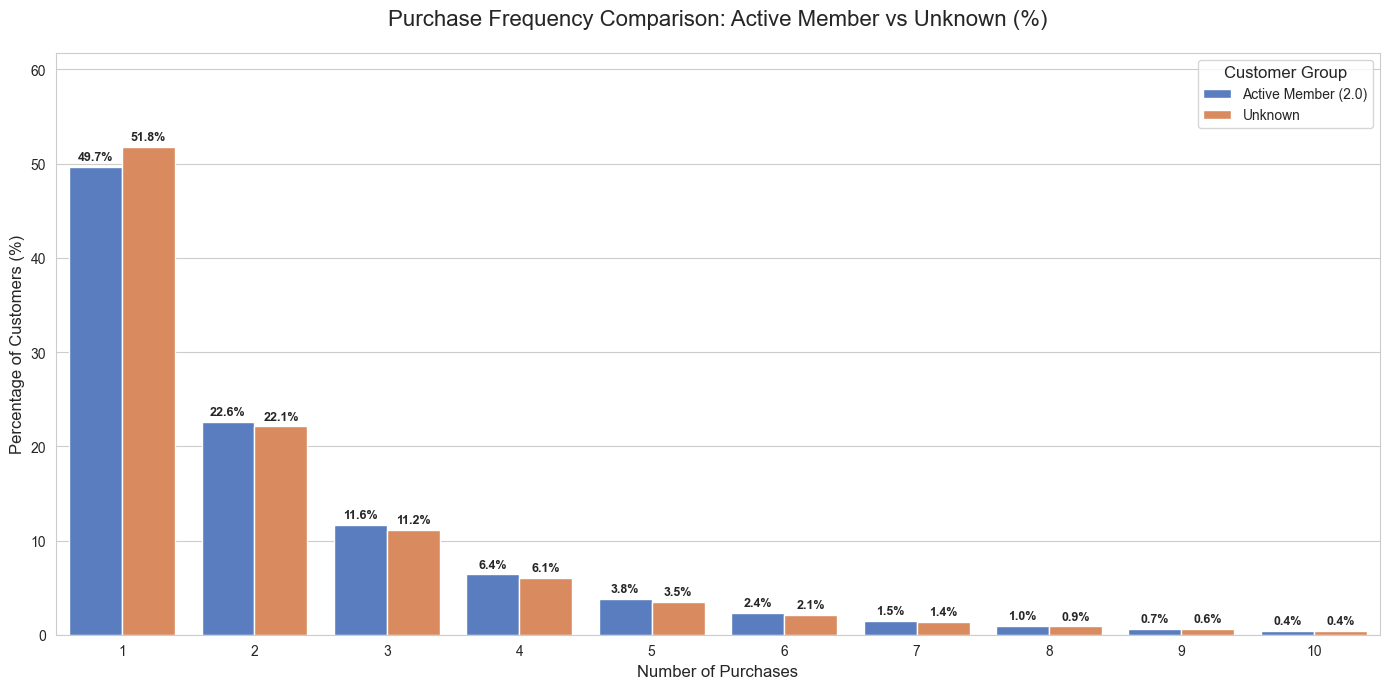

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 기존 회원(Active)과 Unknown 데이터 추출 및 구매 횟수 계산
# Active 회원 (Status 2.0)
active_freq = final_df[final_df['club_member_status'] == 2.0].groupby('customer_id').size().reset_index(name='purchase_count')
active_freq['Group'] = 'Active Member (2.0)'

# Unknown 고객
unknown_freq = final_df[final_df['age_segment'] == 'Unknown'].groupby('customer_id').size().reset_index(name='purchase_count')
unknown_freq['Group'] = 'Unknown'

# 2. 두 데이터 합치기 및 10회 이하로 필터링
combined_df = pd.concat([active_freq, unknown_freq])
plot_df = combined_df[combined_df['purchase_count'] <= 10]

# 3. 그룹별 비율(%) 계산을 위한 데이터프레임 생성
# 각 그룹별로 전체 고객 수를 구해서 비율을 직접 계산합니다.
counts = plot_df.groupby(['Group', 'purchase_count']).size().reset_index(name='count')
totals = plot_df.groupby('Group').size().reset_index(name='total')
final_plot_df = pd.merge(counts, totals, on='Group')
final_plot_df['Percentage'] = (final_plot_df['count'] / final_plot_df['total']) * 100

# 4. 시각화 설정
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# 5. 막대 그래프 그리기 (그룹별 비교)
ax = sns.barplot(data=final_plot_df, x='purchase_count', y='Percentage', hue='Group', palette='muted')

# 6. 막대 위에 비율(%) 텍스트 추가
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 0이 아닌 경우에만 표시
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    fontsize=9, fontweight='bold',
                    xytext=(0, 7), 
                    textcoords='offset points')

# 7. 그래프 꾸미기
plt.title('Purchase Frequency Comparison: Active Member vs Unknown (%)', fontsize=16, pad=20)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Percentage of Customers (%)', fontsize=12)
plt.legend(title='Customer Group', title_fontsize='12', fontsize='10')
plt.ylim(0, final_plot_df['Percentage'].max() + 10) # 텍스트 공간 확보

plt.tight_layout()
# 파일로 저장
plt.savefig('comparison_active_vs_unknown.png')

단발성 고객(구매횟수 1회)의 비율이 2.1%차이가 있다.


unknown이 단발성 고객 비율이 2.1% 더 높다. 의미있는 차이일까?

전체 고객의 고객당 구매횟수 분포 시각화

C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\2738736357.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plot_data_all, x='purchase_count', palette='Blues_r')


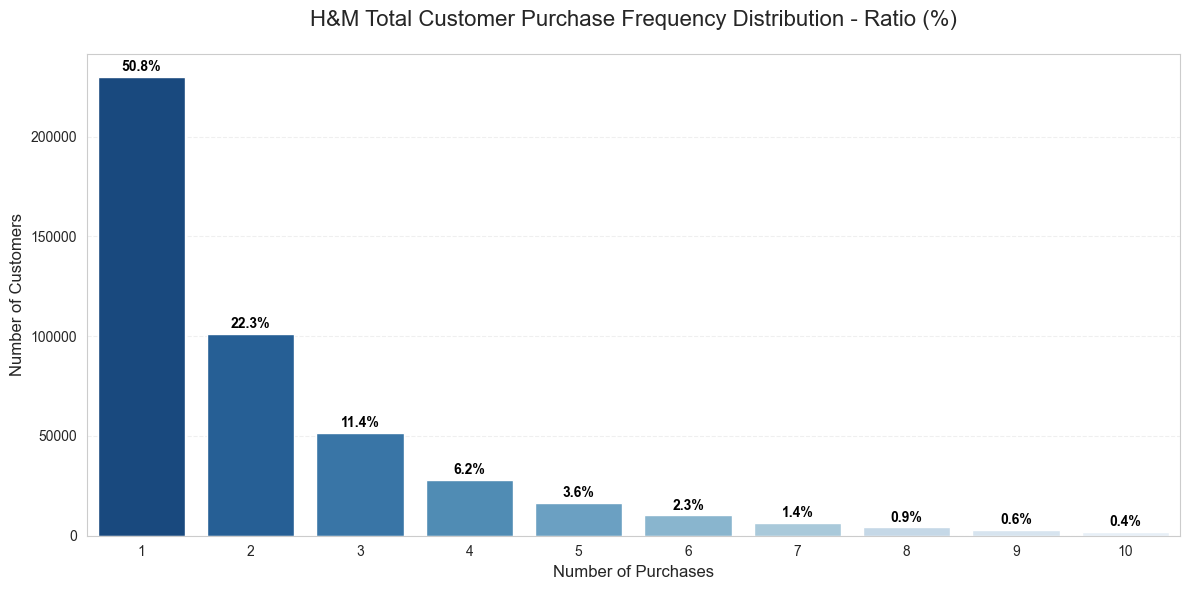

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 모든 고객별로 구매 횟수(Frequency) 계산
total_customer_freq = final_df.groupby('customer_id').size().reset_index(name='purchase_count')

# 분석 대상 데이터 (구매 횟수 10회 이하)
plot_data_all = total_customer_freq[total_customer_freq['purchase_count'] <= 10]
# 비율 계산을 위한 전체 고객 수
total_customers_all = len(plot_data_all)

# 2. 시각화 설정
plt.figure(figsize=(12, 6))

# 3. 구매 횟수별 고객 수 그래프
sns.countplot(data=plot_data_all, x='purchase_count', palette='Blues_r')

# 4. 그래프 꾸미기
plt.title('H&M Total Customer Purchase Frequency Distribution - Ratio (%)', fontsize=16, pad=20)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 5. 막대 위에 비율(%) 표시하기
ax = plt.gca()
for p in ax.patches:
    # 비율 계산: (막대 높이 / 전체 고객 수) * 100
    percentage = f'{(100 * p.get_height() / total_customers_all):.1f}%'
    
    # 위치 지정
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    
    ax.annotate(percentage, (x, y),
                ha='center', va='center', fontsize=10, 
                fontweight='bold', color='black', xytext=(0, 7),
                textcoords='offset points')

plt.tight_layout()
# 파일로 저장하여 발표 자료에 활용하세요!
plt.savefig('total_purchase_ratio.png')

unknown과 기존고객(2)의 고객당 구매횟수 분포 비교 시각화

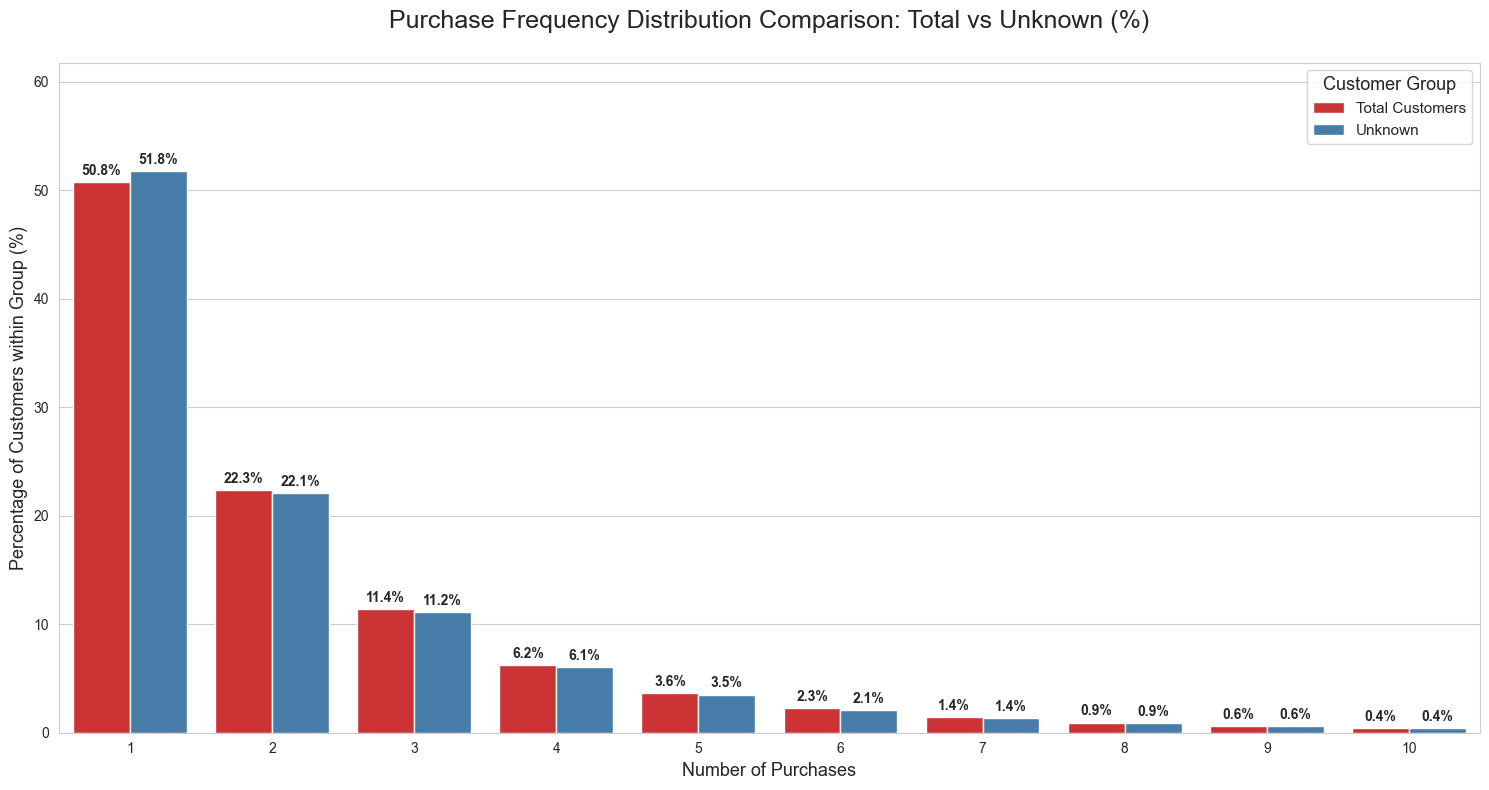

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 각 그룹별 구매 횟수 계산
# 전체 고객 (Total)
total_freq = final_df.groupby('customer_id').size().reset_index(name='purchase_count')
total_freq['Group'] = 'Total Customers'

# Unknown 고객
unknown_freq = final_df[final_df['age_segment'] == 'Unknown'].groupby('customer_id').size().reset_index(name='purchase_count')
unknown_freq['Group'] = 'Unknown'

# 2. 데이터 합치기 및 범위 제한 (가독성을 위해 1~10회 구매자 위주로 분석)
combined_df = pd.concat([total_freq, unknown_freq])
plot_df = combined_df[combined_df['purchase_count'] <= 10]

# 3. 그룹별 비율(%) 계산
# 전체 고객 내 비중과 Unknown 내 비중을 각각 계산합니다.
counts = plot_df.groupby(['Group', 'purchase_count']).size().reset_index(name='count')
totals = plot_df.groupby('Group').size().reset_index(name='total')
final_plot_df = pd.merge(counts, totals, on='Group')
final_plot_df['Percentage'] = (final_plot_df['count'] / final_plot_df['total']) * 100

# 4. 시각화 설정
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# 5. 막대 그래프 그리기 (Side-by-side 비교)
ax = sns.barplot(data=final_plot_df, x='purchase_count', y='Percentage', hue='Group', palette='Set1')

# 6. 막대 위에 비율(%) 텍스트 추가
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    fontsize=10, fontweight='bold',
                    xytext=(0, 8), 
                    textcoords='offset points')

# 7. 그래프 제목 및 라벨
plt.title('Purchase Frequency Distribution Comparison: Total vs Unknown (%)', fontsize=18, pad=25)
plt.xlabel('Number of Purchases', fontsize=13)
plt.ylabel('Percentage of Customers within Group (%)', fontsize=13)
plt.legend(title='Customer Group', title_fontsize='13', fontsize='11')
plt.ylim(0, final_plot_df['Percentage'].max() + 10) # 텍스트 표시 공간 확보

plt.tight_layout()
# 파일 저장
plt.savefig('total_vs_unknown_distribution.png')

unknown과 전체 고객의 1인단 구매횟수 분포가 많이 유사

역시 unknown은 전연령대의 혼합집단인가??

20대,30대,50대,unknown의 1인당 구매횟수 분포 비교 시각화

C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\468130243.py:33: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\osey5\AppData\Local\Temp\ipykernel_17200\468130243.py:34: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.savefig('purchase_freq_distribution.png')
c:\Users\osey5\Desktop\cross-gen-biz-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


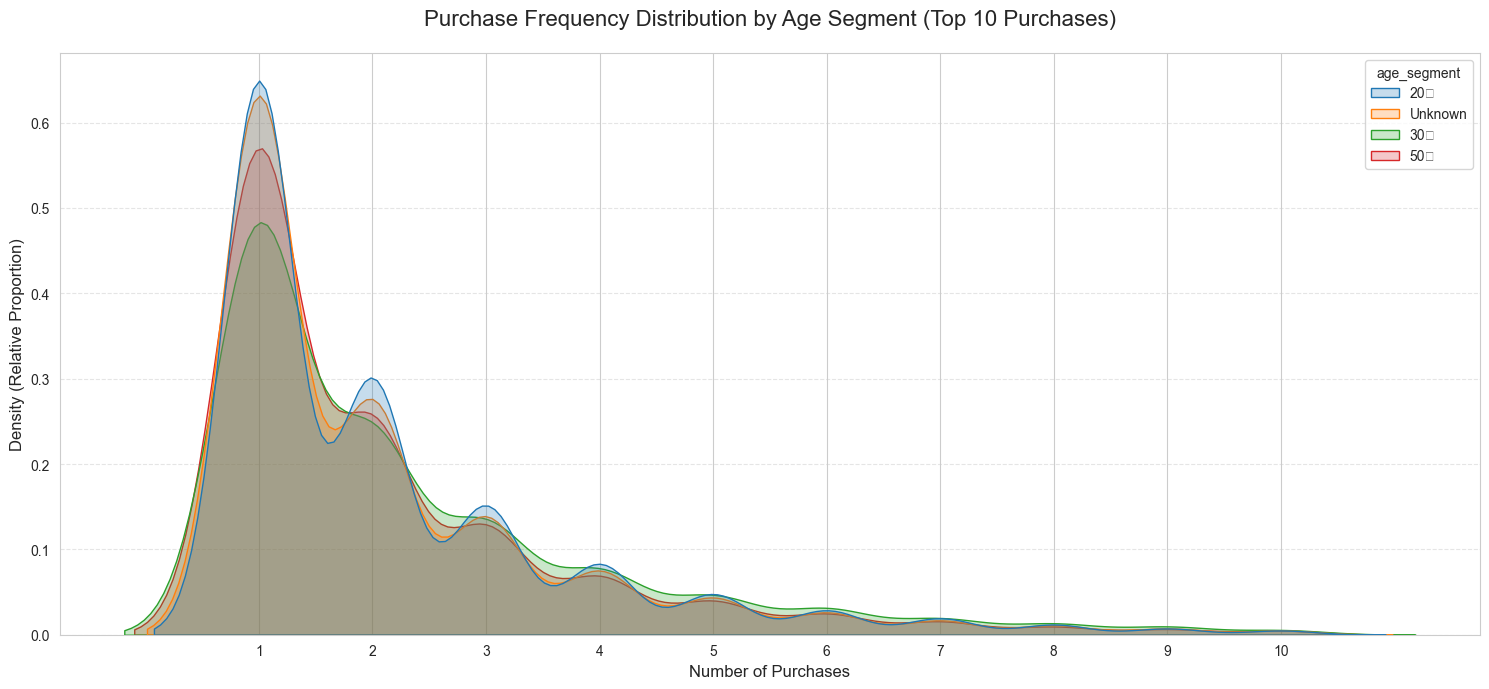

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 모든 고객별로 구매 횟수(Frequency) 계산
# 고객 한 명(customer_id)이 각 연령대(age_segment)에서 총 몇 번 샀는지 세기
customer_freq_all = final_df.groupby(['customer_id', 'age_segment']).size().reset_index(name='purchase_count')

# 2. 시각화할 주요 그룹 설정 (전체적인 비교를 위해 20대, 30대, 50대, Unknown 포함)
target_segments = ['20대', '30대', '50대', 'Unknown']
plot_df = customer_freq_all[customer_freq_all['age_segment'].isin(target_segments)]

# 3. 시각화 설정
plt.figure(figsize=(15, 7))

# 4. 연령대별 구매 횟수 분포 비교 (비중으로 보기 위해 common_norm=False 설정)
# 멘토님 조언대로 '수량'의 차이(20대가 훨씬 많음) 때문에 그래프가 왜곡되는 것을 막기 위해 
# 각 집단 내에서의 '비율(Density)'로 비교합니다.
sns.kdeplot(data=plot_df[plot_df['purchase_count'] <= 10], 
            x='purchase_count', 
            hue='age_segment', 
            common_norm=False, 
            fill=True, 
            bw_adjust=2)

# 5. 그래프 꾸미기
plt.title('Purchase Frequency Distribution by Age Segment (Top 10 Purchases)', fontsize=16, pad=20)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Density (Relative Proportion)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('purchase_freq_distribution.png')

20대와 제일 유사하다.

30대가 단발성 고객이 눈에 띄게 적다. 30대에 충성고객이 많다?






결론1. unknown을 전환하면 매출이 증가한다"는 근거가 부족할 것 같다.

but, 매출증가가 아닌 회원의 다른 이점은 어필할 수 있지 않을까?

ex)'데이터 블랙홀'을 해소하고 개인화 마케팅 기반을 다지는 차원??



결론2. unknown의 거래성향이 2030대와 비슷하다기보다 전체 고객의 거래성향과 비슷하다?

--> unknown은 h&m고객의 22%를 차지하는 중요한 집단이다. unknown의 소비패턴도 함께 분석하자??




--->온/오프라인 연령대별 트렌드 분석 

연령대별 온/오프라인 비율은 비슷하다 다 온라인이 높음

아티클 테이블에서 트렌드를 분석해야겠다...


In [51]:
final_df['age_segment'].value_counts(normalize=True) * 100

age_segment
20대        31.682885
Unknown    22.472241
30대        15.811638
50대        12.995565
40대        12.092479
60대 이상      3.633686
10대         1.311507
Name: proportion, dtype: float64